# Part 2: other environments and RL training
---

In this notebook we will go over some of the variations of `greenCrabEnv` available in this package, and over the syntax for training RL algorithms on instances of these environments.

## 0. Setup
---
As with Part 1 of this series, uncomment the following cell in order to install our package if you haven't done so already. After that restart the jupyter kernel.

In [1]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached typing-3.7.4.3-py3-none-any.whl
  Building editable for rl4greencrab (pyproject.toml) ... done
  Created wheel for rl4greencrab: filename=rl4greencrab-1.0.0-py2.py3-none-any.whl size=1073 sha256=b125839fccc41947614acd0fb477a4cd383c45dfc4c4d3f62424b7ba0fe2f36b
  Stored in directory: /tmp/pip-ephem-wheel-cache-47htzc17/wheels/e9/7e/e6/00c4b11a2574abd59d64425d537139e25fadbde37f002c4dba
Successfully built rl4greencrab
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install gym
%pip install optuna
%pip install logging
%pip install jupyterlab jupyterlab-optuna
%pip install rl_zoo3
%pip install tensorflow

  Using cached gym-0.26.2-py3-none-any.whl
  Using cached gym_notices-0.0.8-py3-none-any.whl.metadata (1.0 kB)
Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached optuna-3.6.1-py3-none-any.whl.metadata (17 kB)
Using cached optuna-3.6.1-py3-none-any.whl (380 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached logging-0.4.9.6-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached jupyterlab_optuna-0.1.0-py3-none-any.whl
  Using cached optuna_dashboard-0.16.1-py3-none-any.whl.metadata (7.0 kB)
  Using cached bottle-0.12.25-py3-none-any.whl.metadata (1.8 kB)
Using cached optuna_dashboard-0.16.1-py3-none-any.whl (8.4 MB)
Using cached bottle-0.12.25-py3-none-any.whl (90 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached rl_zoo3-2.3.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached gymnasium-0.29.1

In [5]:
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd 
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, geom_violin, facet_grid, labs, theme, facet_wrap

from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC
from stable_baselines3.common.env_util import make_vec_env

from rl4greencrab import greenCrabSimplifiedEnv, simulator

import gym

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances
import logging
import inspect

In [301]:
logging.basicConfig(filename="/home/rstudio/env_log.txt" , format='%(levelname)s: %(message)s', level=logging.DEBUG)

## 1. Other envs
---

We will go over two other envs provided by our package: `greenCrabSimplifiedEnv` and `timeSeriesEnv`.
Let's focus on the first one of these envs.

### greenCrabSimplifiedEnv

`greenCrabSimplifiedEnv` is closely related to `greenCrabEnv` and only varies in small aspects.
Let's examine these aspecs one by one.
The first aspect is its action space:

In [50]:
gcse = greenCrabSimplifiedEnv()
gcse.action_space

Box(-1.0, 1.0, (3,), float32)

Actions in this `greenCrabSimplifiedEnv` are between -1 and +1 (in contrast to `greenCrabEnv` where they were in [0, 2000]). 
This difference in action space is purely conceptual: we linearly associate the segment [-1, 1] to the segment [0, 2000] so that, e.g., an action of -1 corresponds to 0 traps laid, an action of 0 corresponds to 1000 traps laid, and an action of +1 corresponds to 2000 traps laid.
Mathematically, this transformation is:
$$a = A / 1000 - 1$$,
where $A\in[0,2000]$ and $a\in[-1,1]$.
This transformation of action space is performed because of purely computational reasons related to hyperparameter tuning of RL algorithms.

A second difference of `greenCrabSimplifiedEnv` with respect to `greenCrabEnv` is in its observation space.

In [22]:
gcse.observation_space

Box(-1.0, 1.0, (2,), float32)

In [23]:
gcse.reset()

(array([-1., -1.], dtype=float32), {})

Here, observations are vectors with *three* components instead of nine, and they are [-1, 1] valued.
E.g., consider the following observation after a second time-step:

In [51]:
gcse.step(np.float32([-0.5, -0.5, -0.5]))[0], gcse.step(np.float32([-0.5, -0.5, -0.5]))[0], gcse.step(np.float32([-0.5, -0.5, -0.5]))[0]

(array([-1., -1.], dtype=float32),
 array([-1.        , -0.99994665], dtype=float32),
 array([-0.9997333, -0.9994533], dtype=float32))

These three numbers correspond to: 1. the catch per 100 traps in the first five months of the year, 2. the catch per 100 traps in the later four months of the year, 3. the number of traps.
These three numbers are transformed to [-1, 1] in a similar fashion to eq. (1).

This simplifies the observations, making it easier for RL algorithms to exploit the information they provide.
Because of this, we will train our algorithms on `greenCrabSimplifiedEnv` rather than `greenCrabEnv`.

### timeSeriesEnv

TBD.

## 2. Training and evaluating RL algos
---

Here we cover some basic syntax for training RL algorithms on our envs.
We use short train times for the sake of brevity in this example.
Typical run-times might need upwards of 1 million time-steps, or possibly up to 10 million time-steps to converge.
This number will, however, depend on the particular algorithm used.

**Note:** This package also provides a more ergonomic syntax for training through the `train.py` script. 
To train models this way, run the following command on the terminal:

`python scripts/train.py -f hyperpars/ppo-gcse.yml`

There, we encode the input to the training algorithm as a YAML file.

In [2]:
config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,

        'loss_a': 0.2,
        'loss_b': 5,
        'loss_c': 5,
        
        'action_reward_exponent': 10,
    }

In [3]:
gcse = greenCrabSimplifiedEnv(config=config)
vec_env = make_vec_env(greenCrabSimplifiedEnv, n_envs=12)
eval_envs = vec_env

### Config

In [4]:
N_TRIALS = 15  # Maximum number of trials
N_JOBS = 1 # Number of jobs to run in parallel
N_STARTUP_TRIALS = 5  # Stop random sampling after N_STARTUP_TRIALS
N_EVALUATIONS = 2  # Number of evaluations during the training
N_TIMESTEPS = 2000  # Training budget
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_ENVS = 12
N_EVAL_EPISODES = 10
TIMEOUT = int(30 * 100)  # 120 minutes

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": gcse,
    "tensorboard_log": "/home/rstudio/logs"
}

### Define Search Space

In [5]:
from typing import Any, Dict

import optuna
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from torch import nn as nn
import gym
from rl_zoo3 import linear_schedule
from collections.abc import Callable

def sample_ppo_params(trial: optuna.Trial, n_actions: int, n_envs: int, additional_args: dict) -> Dict[str, Any]:
    """
    Sampler for PPO hyperparams.

    :param trial:
    :return:
    """
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512])
    n_steps = trial.suggest_categorical("n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048])
    gamma = trial.suggest_categorical("gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 0.1, log=True)
    ent_coef = trial.suggest_float("ent_coef", 0.00000001, 0.1, log=True)
    clip_range = trial.suggest_categorical("clip_range", [0.1, 0.2, 0.3, 0.4])
    n_epochs = trial.suggest_categorical("n_epochs", [1, 5, 10, 20])
    gae_lambda = trial.suggest_categorical("gae_lambda", [0.8, 0.9, 0.92, 0.95, 0.98, 0.99, 1.0])
    max_grad_norm = trial.suggest_categorical("max_grad_norm", [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5])
    vf_coef = trial.suggest_float("vf_coef", 0, 1)
    net_arch_type = trial.suggest_categorical("net_arch", ["tiny", "small", "medium"])
    # Uncomment for gSDE (continuous actions)
    # log_std_init = trial.suggest_float("log_std_init", -4, 1)
    # Uncomment for gSDE (continuous action)
    # sde_sample_freq = trial.suggest_categorical("sde_sample_freq", [-1, 8, 16, 32, 64, 128, 256])
    # Orthogonal initialization
    ortho_init = False
    # ortho_init = trial.suggest_categorical('ortho_init', [False, True])
    # activation_fn = trial.suggest_categorical('activation_fn', ['tanh', 'relu', 'elu', 'leaky_relu'])
    activation_fn_name = trial.suggest_categorical("activation_fn", ["tanh", "relu"])
    # lr_schedule = "constant"
    # Uncomment to enable learning rate schedule
    # lr_schedule = trial.suggest_categorical('lr_schedule', ['linear', 'constant'])
    # if lr_schedule == "linear":
    #     learning_rate = linear_schedule(learning_rate)

    # TODO: account when using multiple envs
    if batch_size > n_steps:
        batch_size = n_steps

    # Independent networks usually work best
    # when not working with images
    net_arch = {
        "tiny": dict(pi=[64], vf=[64]),
        "small": dict(pi=[64, 64], vf=[64, 64]),
        "medium": dict(pi=[256, 256], vf=[256, 256]),
    }[net_arch_type]

    activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU, "elu": nn.ELU, "leaky_relu": nn.LeakyReLU}[activation_fn_name]
    return {
        "n_steps": n_steps,
        "batch_size": batch_size,
        "gamma": gamma,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "clip_range": clip_range,
        "n_epochs": n_epochs,
        "gae_lambda": gae_lambda,
        "max_grad_norm": max_grad_norm,
        "vf_coef": vf_coef,
        # "sde_sample_freq": sde_sample_freq,
        "policy_kwargs": dict(
            # log_std_init=log_std_init,
            net_arch=net_arch,
            activation_fn=activation_fn,
            ortho_init=ortho_init,
        ),
    }

### TD3 parameter

In [327]:
def sample_td3_params(trial: optuna.Trial, n_actions: int, n_envs: int, additional_args: dict) -> Dict[str, Any]:
    """
    Sampler for TD3 hyperparams.

    :param trial:
    :return:
    """
    gamma = trial.suggest_categorical("gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999])
    #learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 0.1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 100, 128, 256, 512, 1024, 2048])
    buffer_size = trial.suggest_categorical("buffer_size", [int(1e4), int(1e5), int(1e6)])
    # Polyak coeff
    tau = trial.suggest_categorical("tau", [0.001, 0.005, 0.01, 0.02, 0.05, 0.08])

    train_freq = trial.suggest_categorical("train_freq", [1, 4, 8, 16, 32, 64, 128, 256, 512])
    gradient_steps = train_freq

    noise_type = trial.suggest_categorical("noise_type", ["ornstein-uhlenbeck", "normal", None])
    noise_std = trial.suggest_float("noise_std", 0, 1)

    # NOTE: Add "verybig" to net_arch when tuning HER
    net_arch_type = trial.suggest_categorical("net_arch", ["small", "medium", "big"])
    # activation_fn = trial.suggest_categorical('activation_fn', [nn.Tanh, nn.ReLU, nn.ELU, nn.LeakyReLU])

    net_arch = {
        "small": [64, 64],
        "medium": [256, 256],
        "big": [400, 300],
        # Uncomment for tuning HER
        # "verybig": [256, 256, 256],
    }[net_arch_type]

    hyperparams = {
        "gamma": gamma,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "train_freq": train_freq,
        "gradient_steps": gradient_steps,
        "policy_kwargs": dict(net_arch=net_arch),
        "tau": tau,
    }

    """if noise_type == "normal":
        hyperparams["action_noise"] = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions))
    elif noise_type == "ornstein-uhlenbeck":
        hyperparams["action_noise"] = OrnsteinUhlenbeckActionNoise(
            mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions)
        )"""

    """if additional_args["using_her_replay_buffer"]:
        hyperparams = sample_her_params(trial, hyperparams, additional_args["her_kwargs"])"""

    return hyperparams

### TQC parameter

In [326]:
def sample_sac_params(trial: optuna.Trial, n_actions: int, n_envs: int, additional_args: dict) -> Dict[str, Any]:
    """
    Sampler for SAC hyperparams.

    :param trial:
    :return:
    """
    gamma = trial.suggest_categorical("gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999])
    #learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 0.1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256, 512, 1024, 2048])
    buffer_size = trial.suggest_categorical("buffer_size", [int(1e4), int(1e5), int(1e6)])
    learning_starts = trial.suggest_categorical("learning_starts", [0, 1000, 10000, 20000])
    # train_freq = trial.suggest_categorical('train_freq', [1, 10, 100, 300])
    train_freq = trial.suggest_categorical("train_freq", [1, 4, 8, 16, 32, 64, 128, 256, 512])
    # Polyak coeff
    tau = trial.suggest_categorical("tau", [0.001, 0.005, 0.01, 0.02, 0.05, 0.08])
    # gradient_steps takes too much time
    # gradient_steps = trial.suggest_categorical('gradient_steps', [1, 100, 300])
    gradient_steps = train_freq
    # ent_coef = trial.suggest_categorical('ent_coef', ['auto', 0.5, 0.1, 0.05, 0.01, 0.0001])
    ent_coef = "auto"
    # You can comment that out when not using gSDE
    log_std_init = trial.suggest_float("log_std_init", -4, 1)
    # NOTE: Add "verybig" to net_arch when tuning HER
    net_arch_type = trial.suggest_categorical("net_arch", ["small", "medium", "big"])
    # activation_fn = trial.suggest_categorical('activation_fn', [nn.Tanh, nn.ReLU, nn.ELU, nn.LeakyReLU])

    net_arch = {
        "small": [64, 64],
        "medium": [256, 256],
        "big": [400, 300],
        # Uncomment for tuning HER
        # "large": [256, 256, 256],
        # "verybig": [512, 512, 512],
    }[net_arch_type]

    target_entropy = "auto"
    # if ent_coef == 'auto':
    #     # target_entropy = trial.suggest_categorical('target_entropy', ['auto', 5, 1, 0, -1, -5, -10, -20, -50])
    #     target_entropy = trial.suggest_float('target_entropy', -10, 10)

    hyperparams = {
        "gamma": gamma,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "learning_starts": learning_starts,
        "train_freq": train_freq,
        "gradient_steps": gradient_steps,
        "ent_coef": ent_coef,
        "tau": tau,
        "target_entropy": target_entropy,
        "policy_kwargs": dict(log_std_init=log_std_init, net_arch=net_arch),
    }

    """if additional_args["using_her_replay_buffer"]:
        hyperparams = sample_her_params(trial, hyperparams, additional_args["her_kwargs"])"""

    return hyperparams

In [252]:
def sample_tqc_params(trial: optuna.Trial, n_actions: int, n_envs: int, additional_args: dict) -> Dict[str, Any]:
    """
    Sampler for TQC hyperparams.

    :param trial:
    :return:
    """
    # TQC is SAC + Distributional RL
    hyperparams = sample_sac_params(trial, n_actions, n_envs, additional_args)

    n_quantiles = trial.suggest_int("n_quantiles", 5, 50)
    top_quantiles_to_drop_per_net = trial.suggest_int("top_quantiles_to_drop_per_net", 0, n_quantiles - 1)

    hyperparams["policy_kwargs"].update({"n_quantiles": n_quantiles})
    hyperparams["top_quantiles_to_drop_per_net"] = top_quantiles_to_drop_per_net

    return hyperparams

### define objective function

In [325]:
from stable_baselines3.common.callbacks import EvalCallback

class TrialEvalCallback(EvalCallback):
    """
    Callback used for evaluating and reporting a trial.
    
    :param eval_env: Evaluation environement
    :param trial: Optuna trial object
    :param n_eval_episodes: Number of evaluation episodes
    :param eval_freq:   Evaluate the agent every ``eval_freq`` call of the callback.
    :param deterministic: Whether the evaluation should
        use a stochastic or deterministic policy.
    :param verbose:
    """

    def __init__(
        self,
        eval_env: gym.Env,
        trial: optuna.Trial,
        n_eval_episodes: int = 5,
        eval_freq: int = 10000,
        deterministic: bool = True,
        verbose: int = 0,
    ):

        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            # Evaluate policy (done in the parent class)
            super()._on_step()
            self.eval_idx += 1
            # Send report to Optuna
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True

In [254]:
# objective function for PPO only
def objective(trial: optuna.Trial) -> float:
    """
    Objective function using by Optuna to evaluate
    one configuration (i.e., one set of hyperparameters).

    Given a trial object, it will sample hyperparameters,
    evaluate it and report the result (mean episodic reward after training)

    :param trial: Optuna trial object
    :return: Mean episodic reward after training
    """

    kwargs = DEFAULT_HYPERPARAMS.copy() 
    ### YOUR CODE HERE
    # TODO: 
    # 1. Sample hyperparameters and update the default keyword arguments: `kwargs.update(other_params)`
    # 2. Create the evaluation envs
    # 3. Create the `TrialEvalCallback`

    # 1. Sample hyperparameters and update the keyword arguments
    kwargs.update(sample_ppo_params(trial,N_EVAL_ENVS))
    # Create the RL model
    model = PPO(**kwargs)

    # 2. Create envs used for evaluation using `make_vec_env`, `ENV_ID` and `N_EVAL_ENVS`
    eval_env = greenCrabSimplifiedEnv()
    # 3. Create the `TrialEvalCallback` callback defined above that will periodically evaluate
    # and report the performance using `N_EVAL_EPISODES` every `EVAL_FREQ`
    # TrialEvalCallback signature:
    # TrialEvalCallback(eval_env, trial, n_eval_episodes, eval_freq, deterministic, verbose)
    eval_callback = TrialEvalCallback(eval_env, trial, N_EVAL_EPISODES, EVAL_FREQ, deterministic=True)

    ### END OF YOUR CODE

    nan_encountered = False
    try:
        # Train the model
        model.learn(N_TIMESTEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN
        print(e)
        nan_encountered = True
    finally:
        # Free memory
        model.env.close()
        vec_env.close()

    # Tell the optimizer that the trial failed
    if nan_encountered:
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    return eval_callback.last_mean_reward

In [334]:
# objective all models
def objective_flex(model_parameter, model_train):
    """
    Objective function using by Optuna to evaluate
    one configuration (i.e., one set of hyperparameters).

    Given a trial object, it will sample hyperparameters,
    evaluate it and report the result (mean episodic reward after training)

    :param trial: Optuna trial object
    :return: Mean episodic reward after training
    """
    def objective_final(trial: optuna.Trial)->float:
        kwargs = DEFAULT_HYPERPARAMS.copy() 
        ### YOUR CODE HERE
        # TODO: 
        # 1. Sample hyperparameters and update the default keyword arguments: `kwargs.update(other_params)`
        # 2. Create the evaluation envs
        # 3. Create the `TrialEvalCallback`
    
        # 1. Sample hyperparameters and update the keyword arguments
        kwargs.update(model_parameter(trial,N_EVAL_ENVS,1,None))
        # Create the RL model
        model = model_train(**kwargs)
    
        # 2. Create envs used for evaluation using `make_vec_env`, `ENV_ID` and `N_EVAL_ENVS`
        eval_env = greenCrabSimplifiedEnv()
        # 3. Create the `TrialEvalCallback` callback defined above that will periodically evaluate
        # and report the performance using `N_EVAL_EPISODES` every `EVAL_FREQ`
        # TrialEvalCallback signature:
        # TrialEvalCallback(eval_env, trial, n_eval_episodes, eval_freq, deterministic, verbose)
        eval_callback = TrialEvalCallback(eval_env, trial, N_EVAL_EPISODES, EVAL_FREQ, deterministic=True)
    
        ### END OF YOUR CODE
    
        nan_encountered = False
        try:
            # Train the model
            model.learn(N_TIMESTEPS, callback=eval_callback)
        except (AssertionError,ValueError) as e:
            # Sometimes, random hyperparams can generate NaN
            print(e)
            nan_encountered = True
        finally:
            # Check if the current trial has the best accuracy
            if trial.number >= 2:
                if eval_callback.last_mean_reward > study.best_trial.value:
                    print("save the current best model")
                    # model.save("tunning_best_gcse") # save the trained best model
            # Free memory
            model.env.close()
            vec_env.close()
    
        # Tell the optimizer that the trial failed
        if nan_encountered:
            return optuna.exceptions.TrialPruned()
    
        if eval_callback.is_pruned:
            raise optuna.exceptions.TrialPruned()
            
        return eval_callback.last_mean_reward
    return objective_final

In [335]:
objective_PPO = objective_flex(sample_ppo_params, PPO)
objective_TD3 = objective_flex(sample_td3_params, TD3)
objective_TQC = objective_flex(sample_tqc_params, TQC)

[I 2024-06-27 08:11:59,450] A new study created in memory with name: no-name-94593a38-5fb9-46bb-b675-80bbcc3c119f
[I 2024-06-27 08:12:12,349] Trial 0 finished with value: -3275.1096488952635 and parameters: {'gamma': 0.98, 'learning_rate': 2.4272462242392767e-05, 'batch_size': 100, 'buffer_size': 100000, 'tau': 0.005, 'train_freq': 64, 'noise_type': None, 'noise_std': 0.018733588504100895, 'net_arch': 'small'}. Best is trial 0 with value: -3275.1096488952635.
[I 2024-06-27 08:12:26,177] Trial 1 finished with value: -345.6443332731724 and parameters: {'gamma': 0.995, 'learning_rate': 0.00026328047134950084, 'batch_size': 1024, 'buffer_size': 100000, 'tau': 0.005, 'train_freq': 1, 'noise_type': 'ornstein-uhlenbeck', 'noise_std': 0.43020164664616944, 'net_arch': 'medium'}. Best is trial 1 with value: -345.6443332731724.
[I 2024-06-27 08:12:37,561] Trial 2 finished with value: -253.90891904020683 and parameters: {'gamma': 0.9999, 'learning_rate': 0.00022704343271217207, 'batch_size': 16, '

save the current best model


[I 2024-06-27 08:12:50,373] Trial 3 finished with value: -4997.853528594971 and parameters: {'gamma': 0.995, 'learning_rate': 2.3168748830889226e-05, 'batch_size': 1024, 'buffer_size': 10000, 'tau': 0.08, 'train_freq': 256, 'noise_type': 'normal', 'noise_std': 0.33376209655776845, 'net_arch': 'big'}. Best is trial 2 with value: -253.90891904020683.
[I 2024-06-27 08:13:01,544] Trial 4 finished with value: -345.06874655485154 and parameters: {'gamma': 0.9999, 'learning_rate': 0.0019358888408996398, 'batch_size': 64, 'buffer_size': 1000000, 'tau': 0.01, 'train_freq': 4, 'noise_type': 'ornstein-uhlenbeck', 'noise_std': 0.5864589918418349, 'net_arch': 'medium'}. Best is trial 2 with value: -253.90891904020683.
[I 2024-06-27 08:13:13,801] Trial 5 pruned. 
[I 2024-06-27 08:13:20,024] Trial 6 pruned. 
[I 2024-06-27 08:13:33,485] Trial 7 finished with value: -252.83541314793985 and parameters: {'gamma': 0.9, 'learning_rate': 0.066005864227354, 'batch_size': 512, 'buffer_size': 1000000, 'tau': 0

save the current best model


[I 2024-06-27 08:13:39,744] Trial 8 pruned. 
[I 2024-06-27 08:13:52,616] Trial 9 finished with value: -252.85110940700397 and parameters: {'gamma': 0.9, 'learning_rate': 0.007404516938672579, 'batch_size': 512, 'buffer_size': 1000000, 'tau': 0.02, 'train_freq': 32, 'noise_type': 'normal', 'noise_std': 0.15667996421110852, 'net_arch': 'big'}. Best is trial 7 with value: -252.83541314793985.
[I 2024-06-27 08:13:57,177] Trial 10 pruned. 
[I 2024-06-27 08:14:03,349] Trial 11 pruned. 
[I 2024-06-27 08:14:15,795] Trial 12 finished with value: -252.90281955052632 and parameters: {'gamma': 0.9, 'learning_rate': 0.01446185808444912, 'batch_size': 512, 'buffer_size': 1000000, 'tau': 0.001, 'train_freq': 128, 'noise_type': 'normal', 'noise_std': 0.27046678279021413, 'net_arch': 'big'}. Best is trial 7 with value: -252.83541314793985.
[I 2024-06-27 08:14:21,901] Trial 13 pruned. 
[I 2024-06-27 08:14:27,968] Trial 14 pruned. 


Number of finished trials:  15
Best trial:
  Value: -252.83541314793985
  Params: 
    gamma: 0.9
    learning_rate: 0.066005864227354
    batch_size: 512
    buffer_size: 1000000
    tau: 0.02
    train_freq: 128
    noise_type: normal
    noise_std: 0.7322559894173697
    net_arch: big
  User attrs:


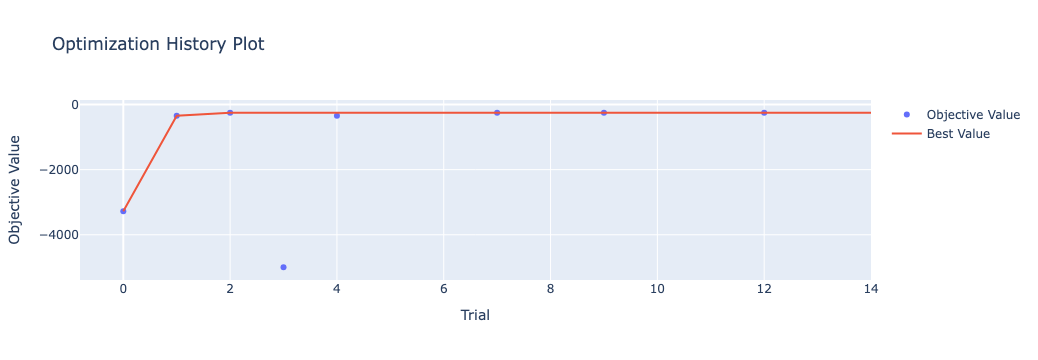

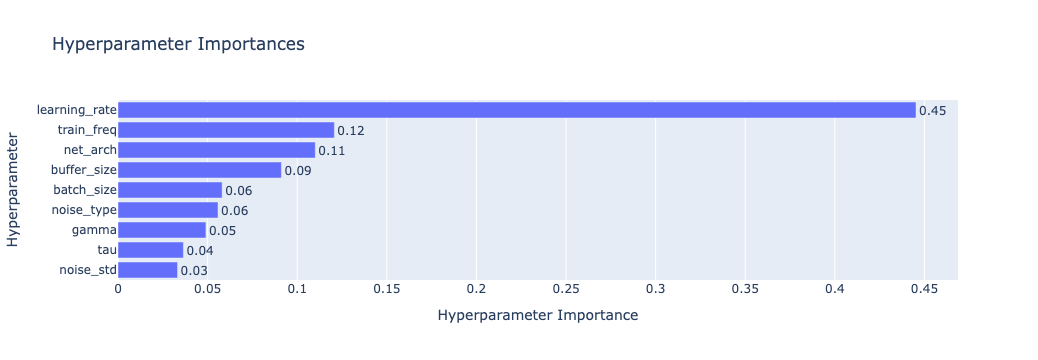

In [336]:
import torch as th

# Set pytorch num threads to 1 for faster training
th.set_num_threads(1)
# Select the sampler, can be random, TPESampler, CMAES, ...
sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
# Do not prune before 1/3 of the max budget is used
pruner = MedianPruner(
    n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_EVALUATIONS // 3
)
# Create the study and start the hyperparameter optimization
study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")

try:
    study.optimize(objective_TD3, n_trials=N_TRIALS, n_jobs=N_JOBS, timeout=TIMEOUT)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

print("  User attrs:")
for key, value in trial.user_attrs.items():
    print(f"    {key}: {value}")

# Write report
study.trials_dataframe().to_csv("study_results_a2c_cartpole.csv")

fig1 = plot_optimization_history(study)
fig2 = plot_param_importances(study)

fig1.show()
fig2.show()

### PPO

In [28]:
gcse = greenCrabSimplifiedEnv(config=config)
vec_env = make_vec_env(greenCrabSimplifiedEnv, n_envs=12)

In [36]:
#{'batch_size': 64, 'n_steps': 512, 'gamma': 0.9, 'learning_rate': 1.7981161785233295e-05, 'ent_coef': 1.706637615300967e-08, 'clip_range': 0.4, 'n_epochs': 20, 'gae_lambda': 0.8, 'max_grad_norm': 5, 'vf_coef': 0.7807332338047879, 'net_arch': 'tiny', 'activation_fn': 'tanh'}
model = PPO("MlpPolicy", vec_env, verbose=0, 
            batch_size =  64, 
            n_steps = 32, 
            gamma = 0.95, 
            learning_rate = 0.1447561168646137, 
            ent_coef = 7.676877009214456e-07, 
            clip_range =  0.1, 
            n_epochs = 20, 
            gae_lambda = 0.9, 
            max_grad_norm = 5, 
            vf_coef = 0.9694540149524578, 
            tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=50000, 
	progress_bar=True,
)
model.save("ppo_gcse_short")

Output()

### TD3

In [304]:
model = TD3("MlpPolicy", gcse, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("td3_gcse")

Output()

### TQC

In [305]:
model = TQC("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("tqc_gcse")

Output()

## 3. Loading and evaluating RL algos
---

In [27]:
# ppoAgent = PPO.load("tunning_best_gcse_ppo_config_1")
ppoAgent = PPO.load("ppo_gcse_short")
td3Agent = TD3.load("td3_gcse")
tqcAgent = TQC.load("./study_results/tunning_best_gcse_tqc_config_2")
tunningAgent_tqc = TQC.load("./study_results/tunning_best_gcse_tqc")
tunningAgent = TD3.load("./study_results/tunning_best_gcse")
evalEnv = greenCrabSimplifiedEnv(config=config)

In [25]:
from stable_baselines3.common.evaluation import evaluate_policy

### PPO

In [26]:
mean_rew, std_rew = evaluate_policy(ppoAgent, evalEnv)
print(f"PPO reward = {mean_rew:.5f} +/- {std_rew:.5f}")

PPO reward = -252.93415 +/- 0.11315


### TD3

In [20]:
mean_rew, std_rew = evaluate_policy(td3Agent, evalEnv)
print(f"TD3 reward = {mean_rew:.5f} +/- {std_rew:.5f}")

TD3 reward = -97.85113 +/- 0.25894


### TQC

In [21]:
mean_rew, std_rew = evaluate_policy(tqcAgent, evalEnv)
print(f"TQC reward = {mean_rew:.5f} +/- {std_rew:.5f}")

TQC reward = -0.00460 +/- 0.00010


In [22]:
mean_rew, std_rew = evaluate_policy(tunningAgent, evalEnv)
print(f"TD3 reward = {mean_rew:.5f} +/- {std_rew:.5f}")

TD3 reward = -127.76286 +/- 0.49436


## 4. Timeseries of episodes
---

### PPO

In [ ]:
??greenCrabSimplifiedEnv

In [40]:
evalEnv.init_n_adult = 100
# evalEnv.reset()
evalEnv.step(np.array([-1,-1,-1]))

(array([-1., -1.], dtype=float32), -0.0012105823637123649, False, False, {})

In [7]:
evalEnv.state

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [23]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000e+00,0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.010376e-10,0
2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-6.997695e-10,0
3,3,-1.0,-1.0,-1.0,-1.0,-1.0,-7.173941e-09,0
4,4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.469419e-07,0


In [399]:
evalEvn

1000

<Axes: xlabel='t'>

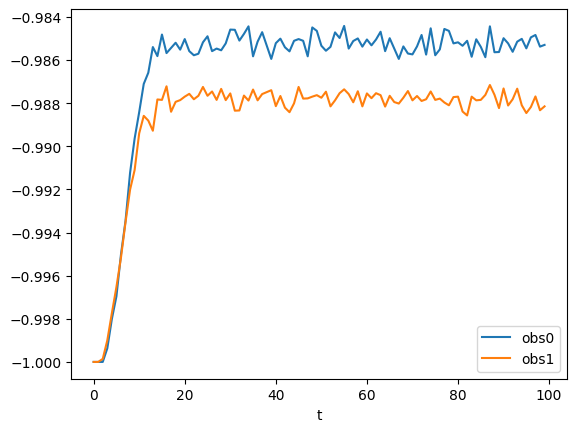

In [58]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0', 'obs1'])

<Axes: xlabel='t'>

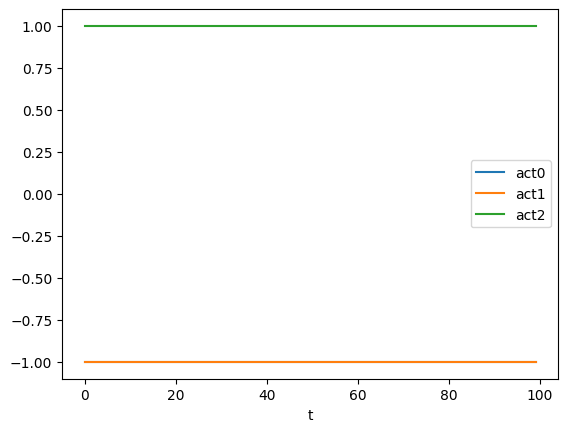

In [59]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

### TD3

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-0.999901,-0.999737,-1.0,0.000000,0
1,1,-1.0,-1.0,-0.999901,-0.999737,-1.0,-0.001380,0
2,2,-1.0,-1.0,-0.999901,-0.999737,-1.0,-0.004526,0
3,3,-1.0,-1.0,-0.999901,-0.999737,-1.0,-0.014796,0
4,4,-1.0,-1.0,-0.999901,-0.999737,-1.0,-0.063516,0


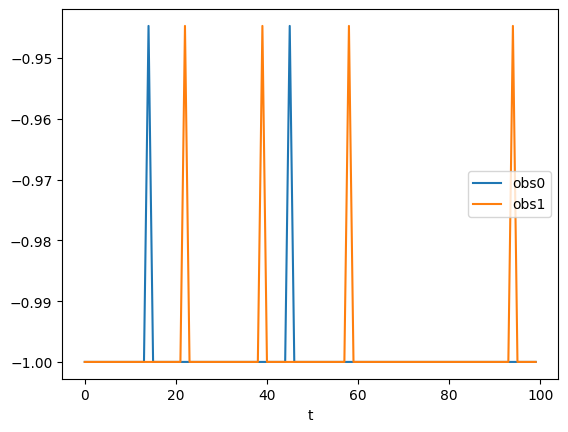

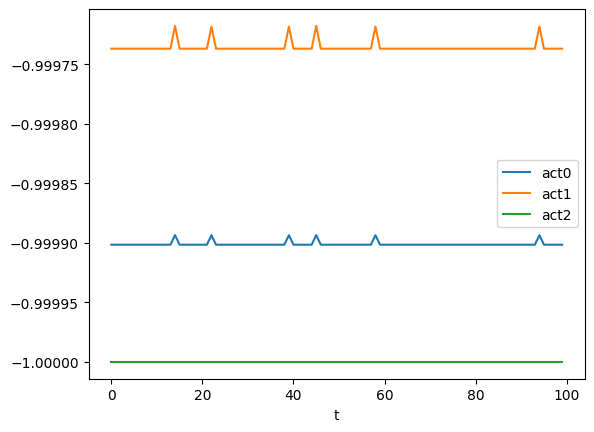

In [13]:
td3Data = simulator(env = evalEnv, agent = tunningAgent).simulate_full_named_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
(
    td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['obs0', 'obs1']),
    td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['act0','act1','act2']),
)
td3DataDF.head()

(<Axes: xlabel='t'>, <Axes: xlabel='t'>)

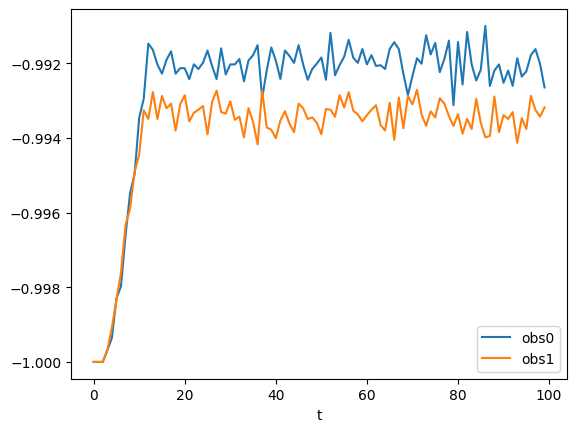

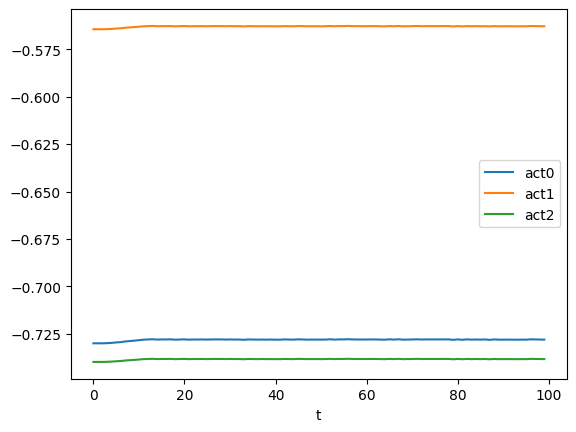

In [14]:
tqcData = simulator(env = evalEnv, agent = tqcAgent).simulate_full_named_obs_acts()
tqcDataDF = pd.DataFrame(tqcData)
(
    tqcDataDF[tqcDataDF.rep == 0].plot(x='t', y =['obs0', 'obs1']),
    tqcDataDF[tqcDataDF.rep == 0].plot(x='t', y =['act0','act1','act2']),
)

In [15]:
tqcDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.000000,-0.729967,-0.564515,-0.739773,0.000000,0
1,1,-1.000000,-1.000000,-0.729967,-0.564515,-0.739773,-13.365323,0
2,2,-1.000000,-1.000000,-0.729967,-0.564515,-0.739773,-26.732564,0
3,3,-0.999689,-0.999689,-0.729882,-0.564445,-0.739707,-40.107972,0
4,4,-0.999358,-0.999089,-0.729750,-0.564335,-0.739603,-53.530137,0
